# Linear Models
In this notebook, we discuss linear regression, shrinkage models and general additive models.
As shrinkage methods we discuss the ridge regression and lasso.
The methods will be discussed on the "House Prices - Advanced Regression Techniques" data set from Kaggle.

## Loading Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from pygam import LinearGAM, s, f
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
import feature_engine.imputation as imp
from feature_engine.encoding import OneHotEncoder

import matplotlib.pyplot as plt

## Loading data
The available data are already split in train and test, hence no transformation needs to be done.

In [4]:
# loading the train set
train = pd.read_csv("../Datasets/house_data/train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# loading test data
test = pd.read_csv("../Datasets/house_data/test.csv")
test.shape

(1459, 80)

In [6]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(train.drop(['Id', 'SalePrice'], axis=1),
                                                    train['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

In [9]:
y_train.describe()

count      1314.000000
mean     181040.624049
std       79048.006112
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      215000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [7]:
test.drop(['Id'],axis = 1, inplace = True)

In [8]:
# get a description
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1314.000000,1081.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1308.000000,1314.000000,1314.000000,...,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,56.959665,69.879741,10597.401065,6.105784,5.589802,1970.940639,1984.783866,103.797401,445.622527,45.291476,...,473.024353,94.680365,47.354642,22.148402,3.170472,14.681126,2.643075,47.331811,6.330289,2007.815068
std,42.217917,24.317125,10425.613524,1.388753,1.122336,30.379817,20.685742,183.440075,460.800205,158.313853,...,215.248094,127.278298,67.545132,61.721089,28.600564,54.860797,39.504255,522.227172,2.705197,1.332716
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7560.000000,5.000000,5.000000,1953.000000,1966.250000,0.000000,0.000000,0.000000,...,326.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9525.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,382.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11613.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,719.000000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [9]:
# looking for NA
vars_with_na = [var for var in X_train.columns if X_train[var].isnull().mean() > 0]
vars_with_na

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [10]:
# Looking at share of missing values
X_train[vars_with_na].isnull().mean()

LotFrontage     0.177321
Alley           0.938356
MasVnrType      0.004566
MasVnrArea      0.004566
BsmtQual        0.024353
BsmtCond        0.024353
BsmtExposure    0.025114
BsmtFinType1    0.024353
BsmtFinType2    0.025114
Electrical      0.000761
FireplaceQu     0.472603
GarageType      0.056317
GarageYrBlt     0.056317
GarageFinish    0.056317
GarageQual      0.056317
GarageCond      0.056317
PoolQC          0.995434
Fence           0.814307
MiscFeature     0.961187
dtype: float64

In [11]:
# types of the variables
X_train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [12]:
vars_cca = [var for var in vars_with_na if X_train[var].isnull().mean() > 0.06]
vars_cca

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

I remove all the variables with more than 5% missing

In [13]:
X_train.shape

(1314, 79)

In [14]:
X_train.drop(vars_cca, axis = 1,inplace = True)
X_test.drop(vars_cca,axis = 1, inplace = True)

In [15]:
X_train.shape

(1314, 73)

In [16]:
X_train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
930,20,RL,8925,Pave,IR1,HLS,AllPub,Inside,Gtl,Timber,...,18,0,0,0,0,0,7,2009,WD,Normal
656,20,RL,10007,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,0,8,2008,WD,Normal
45,120,RL,7658,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,82,0,0,0,0,0,2,2010,WD,Normal
1348,20,RL,16196,Pave,IR3,Low,AllPub,Inside,Gtl,SawyerW,...,25,0,0,0,0,0,8,2007,WD,Normal
55,20,RL,10175,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,407,0,0,0,7,2008,WD,Normal


In [17]:
test.drop(vars_cca,axis=1,inplace = True)

## Imputing the data
Median imputation for numerical variables is applied
Top class imputer tool is used for categorical variables

In [18]:
pipe = Pipeline([
    ('median_imputer', imp.MeanMedianImputer(imputation_method='median')),
    ('frequent_category_imputer', imp.CategoricalImputer(imputation_method='frequent'))
])
pipe.fit(X_train)

Pipeline(steps=[('median_imputer', MeanMedianImputer()),
                ('frequent_category_imputer',
                 CategoricalImputer(imputation_method='frequent'))])

In [19]:
pipe.named_steps['median_imputer'].imputer_dict_

{'MSSubClass': 50.0,
 'LotArea': 9525.0,
 'OverallQual': 6.0,
 'OverallCond': 5.0,
 'YearBuilt': 1972.0,
 'YearRemodAdd': 1993.0,
 'MasVnrArea': 0.0,
 'BsmtFinSF1': 382.0,
 'BsmtFinSF2': 0.0,
 'BsmtUnfSF': 481.5,
 'TotalBsmtSF': 992.5,
 '1stFlrSF': 1092.0,
 '2ndFlrSF': 0.0,
 'LowQualFinSF': 0.0,
 'GrLivArea': 1472.0,
 'BsmtFullBath': 0.0,
 'BsmtHalfBath': 0.0,
 'FullBath': 2.0,
 'HalfBath': 0.0,
 'BedroomAbvGr': 3.0,
 'KitchenAbvGr': 1.0,
 'TotRmsAbvGrd': 6.0,
 'Fireplaces': 1.0,
 'GarageYrBlt': 1980.0,
 'GarageCars': 2.0,
 'GarageArea': 480.0,
 'WoodDeckSF': 0.0,
 'OpenPorchSF': 25.0,
 'EnclosedPorch': 0.0,
 '3SsnPorch': 0.0,
 'ScreenPorch': 0.0,
 'PoolArea': 0.0,
 'MiscVal': 0.0,
 'MoSold': 6.0,
 'YrSold': 2008.0}

In [20]:
pipe.named_steps['frequent_category_imputer'].imputer_dict_

{'MSZoning': 'RL',
 'Street': 'Pave',
 'LotShape': 'Reg',
 'LandContour': 'Lvl',
 'Utilities': 'AllPub',
 'LotConfig': 'Inside',
 'LandSlope': 'Gtl',
 'Neighborhood': 'NAmes',
 'Condition1': 'Norm',
 'Condition2': 'Norm',
 'BldgType': '1Fam',
 'HouseStyle': '1Story',
 'RoofStyle': 'Gable',
 'RoofMatl': 'CompShg',
 'Exterior1st': 'VinylSd',
 'Exterior2nd': 'VinylSd',
 'MasVnrType': 'None',
 'ExterQual': 'TA',
 'ExterCond': 'TA',
 'Foundation': 'PConc',
 'BsmtQual': 'TA',
 'BsmtCond': 'TA',
 'BsmtExposure': 'No',
 'BsmtFinType1': 'Unf',
 'BsmtFinType2': 'Unf',
 'Heating': 'GasA',
 'HeatingQC': 'Ex',
 'CentralAir': 'Y',
 'Electrical': 'SBrkr',
 'KitchenQual': 'TA',
 'Functional': 'Typ',
 'GarageType': 'Attchd',
 'GarageFinish': 'Unf',
 'GarageQual': 'TA',
 'GarageCond': 'TA',
 'PavedDrive': 'Y',
 'SaleType': 'WD',
 'SaleCondition': 'Normal'}

Now we apply the NA imputation to the data set

In [21]:
# let's transform the data with the pipeline
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
X_train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
930,20,RL,8925,Pave,IR1,HLS,AllPub,Inside,Gtl,Timber,...,18,0,0,0,0,0,7,2009,WD,Normal
656,20,RL,10007,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,0,8,2008,WD,Normal
45,120,RL,7658,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,82,0,0,0,0,0,2,2010,WD,Normal
1348,20,RL,16196,Pave,IR3,Low,AllPub,Inside,Gtl,SawyerW,...,25,0,0,0,0,0,8,2007,WD,Normal
55,20,RL,10175,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,407,0,0,0,7,2008,WD,Normal


In [22]:
test = pipe.transform(test)

In [23]:
test.shape

(1459, 73)

## Linear Regression
For the presentation purpose we use only numerical variables

MSSubClass: The building class
LotArea: Lot size in square feet
OverallQual: Overall material and finish quality
OverallCond: Overall condition rating
Exterior1st: Exterior covering on house
BsmtQual: Height of the basement
FullBath: Full bathrooms above grade
Bedroom: Number of bedrooms above basement level
Kitchen: Number of kitchens

In [24]:
X_train_2 =   X_train[['MSSubClass','LotArea','OverallQual',
                     'OverallCond','BedroomAbvGr', 'KitchenAbvGr']]

In [25]:
X_train_2.dtypes

MSSubClass      int64
LotArea         int64
OverallQual     int64
OverallCond     int64
BedroomAbvGr    int64
KitchenAbvGr    int64
dtype: object

Applying a simple linear regression

In [27]:
# create linear regression
regr = linear_model.LinearRegression()
# train model using training set
reg = regr.fit(X_train[['MSSubClass']],y_train)

Looking at the coefficients

In [28]:
# regression coefficients
print('Coefficients: ', reg.coef_)
# intercept
print('intercept: ', reg.intercept_)

Coefficients:  [-155.69878776]
intercept:  189909.1748627338


Plot of the results

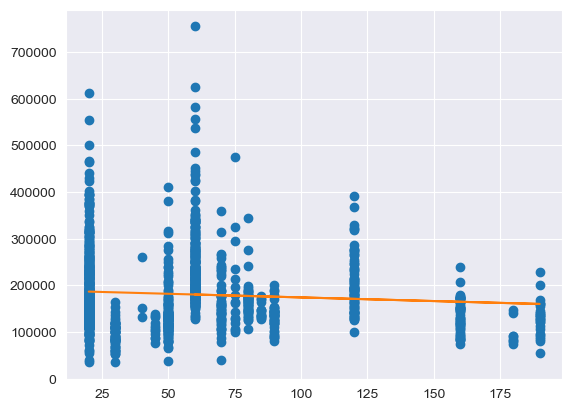

In [29]:
plt.plot(X_train[['MSSubClass']],y_train,'o')
plt.plot(X_train[['MSSubClass']],reg.coef_[0]*X_train[['MSSubClass']]+reg.intercept_)

Multiple linear regression

In [31]:
reg = regr.fit(X_train_2,y_train)

Looking at the parameters

In [32]:
# regression coefficients
print('Coefficients: ', reg.coef_)
# intercept
print('intercept: ', reg.intercept_)

Coefficients:  [-1.74036315e+02  1.26482207e+00  4.41076763e+04 -2.14971789e+02
  6.11912390e+03  9.02494198e+03]
intercept:  -117539.9005759535


## Ridge regression

In [65]:
# define model
model = linear_model.Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -31936.748
Config: {'alpha': 0.99}


In [73]:
# define model
model = linear_model.Ridge(alpha=0.99)
ridge_mod = model.fit(X_train, y_train)

In [79]:
# regression coefficients
print('Coefficients: ', ridge_mod.coef_)
# intercept
print('intercept: ', ridge_mod.intercept_)

Coefficients:  [-1.73996492e+02  1.26484769e+00  4.41064140e+04 -2.14596454e+02
  6.11911729e+03  9.00083851e+03]
intercept:  -117511.60810632716
score:  <bound method RegressorMixin.score of Lasso(alpha=0.99)>


## Lasso

In [76]:
# define model
model = linear_model.Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -31941.541
Config: {'alpha': 0.99}


In [77]:
# define model
model = linear_model.Lasso(alpha=0.99)
ridge_mod = model.fit(X_train, y_train)

In [78]:
# regression coefficients
print('Coefficients: ', ridge_mod.coef_)
# intercept
print('intercept: ', ridge_mod.intercept_)

Coefficients:  [-1.73996492e+02  1.26484769e+00  4.41064140e+04 -2.14596454e+02
  6.11911729e+03  9.00083851e+03]
intercept:  -117511.60810632716


Adding a higher value to show they get 0

In [86]:
# define model
model = linear_model.Lasso(alpha=1000)
ridge_mod = model.fit(X_train, y_train)

In [87]:
# regression coefficients
print('Coefficients: ', ridge_mod.coef_)
# intercept
print('intercept: ', ridge_mod.intercept_)

Coefficients:  [-1.58182433e+02  1.28690679e+00  4.33538225e+04 -0.00000000e+00
  5.19803250e+03  0.00000000e+00]
intercept:  -103198.11258254378
